# CpG set exploration

In [1]:
import joblib
import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter


In [23]:
os.chdir(os.path.expanduser("~/PhD_Workspace/PredictRecurrence/"))


In [3]:
def load_training_data(train_ids, beta_path, clinical_path):
    # load clin data
    clinical_data = pd.read_csv(clinical_path)
    clinical_data = clinical_data.set_index("Sample")
    clinical_data = clinical_data.loc[train_ids]

    # load beta values
    beta_matrix = pd.read_csv(beta_path,index_col=0).T

    # align dataframes
    beta_matrix = beta_matrix.loc[train_ids]

    print("Loaded training data.")

    return beta_matrix, clinical_data


def beta2m(beta, beta_threshold=1e-3):
    beta = np.clip(beta, beta_threshold, 1 - beta_threshold)
    return np.log2(beta / (1 - beta))


In [4]:
fold_dict_path = "./output/CoxNet/ERpHER2n/Methylation/Unadjusted/cvfold_ids.pkl"
anno_path = "./data/raw/EPIC_probeAnnoObj.csv"
infile_train_ids = "./data/train/train_subcohorts/ERpHER2n_train_ids.csv"
infile_betavalues = "./data/train/train_methylation_unadjusted.csv"
infile_clinical = "./data/train/train_clinical.csv"

In [5]:
# Load and preprocess data
train_ids = pd.read_csv(infile_train_ids, header=None).iloc[:, 0].tolist()
beta_matrix, clinical_data = load_training_data(train_ids, infile_betavalues, infile_clinical)

# convert to M-values
mvals = beta2m(beta_matrix, beta_threshold=0.001)

Loaded training data.


In [6]:

try:
    fold_dict = joblib.load(fold_dict_path)
except Exception:
    with open(fold_dict_path, "rb") as f:
        fold_dict = pickle.load(f)

print("Loaded fold_dict with keys:", list(fold_dict.keys()))


Loaded fold_dict with keys: ['fold0', 'fold1', 'fold2', 'fold3', 'fold4']


In [7]:
# Load annotation
anno = pd.read_csv(anno_path)
anno.head()

,illuminaID,chr,start,end,hasUCSCknownGeneOverlap,nameUCSCknownGeneOverlap,numberUCSCknownGeneOverlap,hasUCSCknownGeneUp5kbOverlap,hasUCSCknownGeneDn5kbOverlap,hasUCSCknownTxPromOverlap,...,encodeCreCtcf,encodeChipMeanNcellPeaks,encodeChipUniqueTfPeaks,hasAnyRepeatOverlap,hasMultiRepeatOverlap,hasOneRepeatOverlap,hasRepeatOverlap,repeatClass,repeatFamily,repeatName
0,cg21870274,chr1,69591,69592.0,1,OR4F5,1,0,1,0,...,0,0.000,0,0,0,0,0,NaN,NaN,NaN
1,cg09499020,chr1,817115,817116.0,0,NaN,0,0,0,1,...,1,1.500,8,1,0,1,1,LINE,L1,L1P4
2,cg16535257,chr1,817316,817317.0,0,NaN,0,0,0,1,...,1,1.286,14,0,0,0,0,NaN,NaN,NaN
3,cg06325811,chr1,860948,860949.0,0,NaN,0,0,0,0,...,1,0.000,0,1,0,1,1,LTR,ERV1,LTR2C
4,cg08258224,chr1,864703,864704.0,0,NaN,0,0,0,0,...,0,0.000,0,0,0,0,0,NaN,NaN,NaN


In [8]:
# Filter annotation once for hasAtacOverlap == 1
atac_cpgs = anno["illuminaID"][anno["hasAtacOverlap"] == 1].astype(str).tolist()
atac_cpgs_set = set(atac_cpgs)  # convert once to set for faster intersection

# Loop over all folds
for fold_key in fold_dict.keys():
    features_after_filter1 = fold_dict[fold_key]["features_after_filter1"]
    features_after_filter1 = [str(c) for c in features_after_filter1]

    # Intersection
    overlap = set(features_after_filter1).intersection(atac_cpgs_set)

    print(f"Fold {fold_key}:")
    print(f"  Number of CpGs after filter 1: {len(features_after_filter1)}")
    print(f"  Number of CpGs with ATACoverlap == 1: {len(overlap)}")
    print(f"  Fraction: {len(overlap)/len(features_after_filter1):.2f}\n")



Fold fold0:
  Number of CpGs after filter 1: 20000
  Number of CpGs with ATACoverlap == 1: 3914
  Fraction: 0.20

Fold fold1:
  Number of CpGs after filter 1: 20000
  Number of CpGs with ATACoverlap == 1: 3946
  Fraction: 0.20

Fold fold2:
  Number of CpGs after filter 1: 20000
  Number of CpGs with ATACoverlap == 1: 3866
  Fraction: 0.19

Fold fold3:
  Number of CpGs after filter 1: 20000
  Number of CpGs with ATACoverlap == 1: 3836
  Fraction: 0.19

Fold fold4:
  Number of CpGs after filter 1: 20000
  Number of CpGs with ATACoverlap == 1: 3873
  Fraction: 0.19



In [9]:

# Collect all CpGs selected after filter 1 across folds
all_selected_cpgs = []
for fold_key in fold_dict.keys():
    feats = fold_dict[fold_key]["features_after_filter1"]
    feats = [str(c) for c in feats]
    all_selected_cpgs.extend(feats)

# Count how many times each CpG was selected
cpg_counts = Counter(all_selected_cpgs)

# Convert to DataFrame
cpg_stability_df = pd.DataFrame.from_dict(cpg_counts, orient='index', columns=['n_folds'])
cpg_stability_df.index.name = 'CpG'
cpg_stability_df['fraction_folds'] = cpg_stability_df['n_folds'] / len(fold_dict)

# Sort by most consistently selected
cpg_stability_df = cpg_stability_df.sort_values(['n_folds', 'CpG'], ascending=[False, True])

# Display top 20 most stable CpGs
print("Top 20 most stable CpGs after filter 1:")
display(cpg_stability_df.head(20))



Top 20 most stable CpGs after filter 1:


,n_folds,fraction_folds
CpG,,
cg00000579,5,1.0
cg00002186,5,1.0
cg00002398,5,1.0
cg00002934,5,1.0
cg00003298,5,1.0
cg00005354,5,1.0
cg00006926,5,1.0
cg00007239,5,1.0
cg00009922,5,1.0


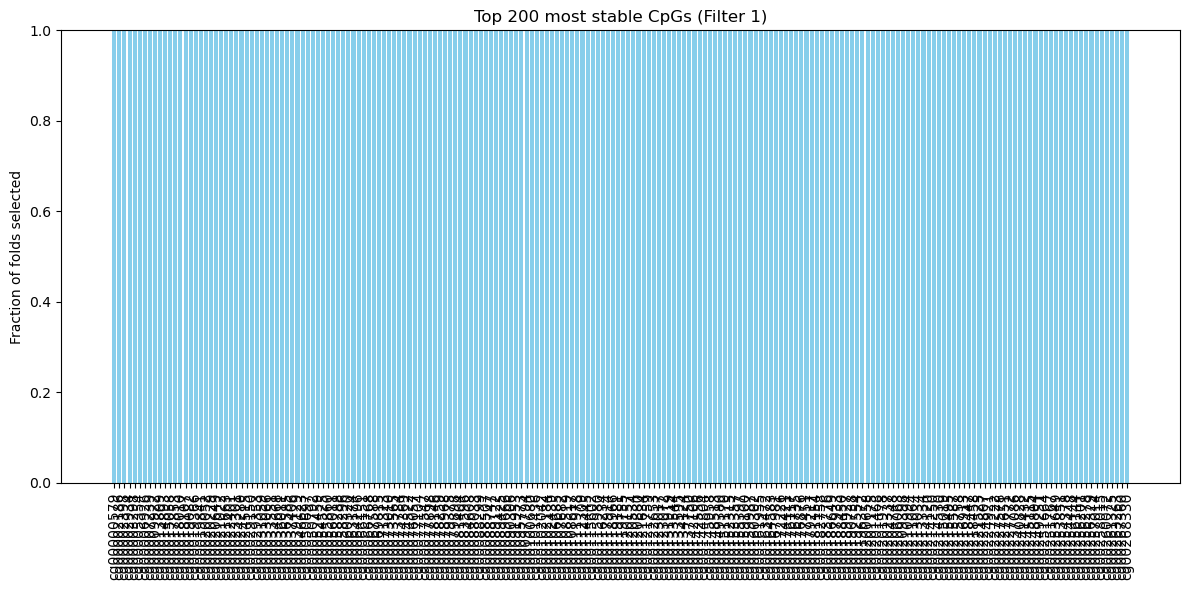

In [10]:

# Take top 20 most stable CpGs
top_n = 200
top_cpgs = cpg_stability_df.head(top_n)

plt.figure(figsize=(12,6))
plt.bar(top_cpgs.index, top_cpgs['fraction_folds'], color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Fraction of folds selected")
plt.title(f"Top {top_n} most stable CpGs (Filter 1)")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [13]:
# Number of folds
n_folds = len(fold_dict)

# Count how many CpGs were selected in 1,2,... folds
selection_counts = cpg_stability_df['n_folds'].value_counts().sort_index()

# Convert to a DataFrame for nicer display
selection_crosstab = pd.DataFrame({
    'n_folds_selected': selection_counts.index,
    'n_CpGs': selection_counts.values
})

print("CpG selection frequency across folds:")
display(selection_crosstab)

# Optional: add fraction
selection_crosstab['perc_CpGs'] = (selection_crosstab['n_CpGs'] / selection_crosstab['n_CpGs'].sum()) * 100
display(selection_crosstab)


CpG selection frequency across folds:


,n_folds_selected,n_CpGs
0,1,1038
1,2,708
2,3,716
3,4,952
4,5,18318


,n_folds_selected,n_CpGs,perc_CpGs
0,1,1038,4.776367
1,2,708,3.257869
2,3,716,3.294681
3,4,952,4.380637
4,5,18318,84.290447


In [24]:
ids_tosave = anno['illuminaID'][anno['hasAtacOverlap']==1]


In [28]:
len(ids_tosave)

205799

In [27]:

with open("./data/set_definitions/CpG_prefiltered_sets/cpg_ids_atac_overlap.txt", "w") as f:
    for id_ in ids_tosave:
        f.write(f"{id_}\n")


In [18]:
# Number of folds
n_folds = len(fold_dict)

# Count how many CpGs were selected in 1,2,... folds
selection_counts = cpg_stability_df['n_folds'].value_counts().sort_index()

# Convert to a DataFrame for nicer display
selection_crosstab = pd.DataFrame({
    'n_folds_selected': selection_counts.index,
    'n_CpGs': selection_counts.values
})

# add fraction
selection_crosstab['perc_CpGs'] = (selection_crosstab['n_CpGs'] / selection_crosstab['n_CpGs'].sum()) * 100

# Make a set of CpGs with ATAC overlap
atac_cpgs_set = set(anno["illuminaID"][anno["hasAtacOverlap"] == 1].astype(str))

# Add column: number of CpGs in each n_folds_selected group that have ATAC overlap
selection_crosstab['n_CpGs_ATACoverlap'] = selection_crosstab['n_folds_selected'].apply(
    lambda n: sum(
        (cpg_stability_df.index[cpg_stability_df['n_folds'] == n].isin(atac_cpgs_set))
    )
)

# Optional: fraction with ATAC overlap
selection_crosstab['fraction_ATACoverlap'] = (selection_crosstab['n_CpGs_ATACoverlap'] / selection_crosstab['n_CpGs']) * 100

display(selection_crosstab)


,n_folds_selected,n_CpGs,perc_CpGs,n_CpGs_ATACoverlap,fraction_ATACoverlap
0,1,1038,4.776367,206,19.845857
1,2,708,3.257869,147,20.762712
2,3,716,3.294681,148,20.670391
3,4,952,4.380637,184,19.327731
4,5,18318,84.290447,3551,19.385304
